# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
colors = sns.color_palette('Blues_d')[0:6]
matplotlib.rcParams['figure.facecolor'] = 'white'

In [13]:
dataset = pd.read_csv('DataAnalyst.csv')
coli = pd.read_csv("coli.csv")

In [51]:
def clean_data(df):
    df.drop(df.columns[0], axis=1, inplace=True)
    df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.split('(')[0])
    df.fillna("Not Available", inplace=True)
    df["Company Name"] = df["Company Name"].apply(lambda x: x.split('\n')[0])
    df["Size"] = df["Size"].apply(lambda x: x.split('employees')[0])
    df["Size"] = df["Size"].apply(lambda x: x.replace(" to ", "-"))
    df["Type of ownership"] = df["Type of ownership"].apply(lambda x: "Unknown" if x == "-1" else x)
    return df

# helper function for data cleaning to extract the state
def get_state(x):
    if x.count(',') > 1:
        return x.split(', ')[2]
    else:
        return x.split(', ')[1]

# convert salary range to concrete number we can work with
def get_salary_range(x):
    if x == '-1':
        return -1
    range_salary = x.split('-')
    n1 = range_salary[0].replace('$', '').replace('K', '').replace(' ', '')
    n2 = range_salary[1].replace('$', '').replace('K', '').replace(' ', '')
    
    range_salary = np.arange(int(n1), int(n2)+1, 1)
    range_salary = np.median(range_salary) * 1000
    return range_salary

def account_for_coli(df):
    df = df[df['Cost of Living Index'].notna()]
    df['Cost of Living Index'] = df['Cost of Living Index'] / 100

    # make a new column, salary adjusted for cost of living
    df['Adjusted salary'] = df['Salary'] / df['Cost of Living Index']
    df['Adjusted salary'] = df['Adjusted salary'].astype(int)
    return df

dataset = clean_data(dataset)

dataset['State'] = dataset['Location'].apply(get_state)

dataset['City'] = dataset['Location'].apply(lambda x: x.split(',')[0])
    
dataset = dataset.merge(coli, how='left', left_on=['City', 'State'], right_on=['City', 'State'])
dataset['Salary'] = dataset['Salary Estimate'].apply(get_salary_range)

dataset = account_for_coli(dataset)

output = dataset[['Location', 'Type of ownership', 'Rating', 'Salary', 'Cost of Living Index', 'Adjusted salary']]

/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_92252/3446166409.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cost of Living Index'] = df['Cost of Living Index'] / 100
/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_92252/3446166409.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Adjusted salary'] = df['Salary'] / df['Cost of Living Index']
/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_92252/3446166409.py:36: SettingWithCopyWarning: 
A value is trying 

In [52]:
output.to_csv('cleaned_data.csv', index=False)

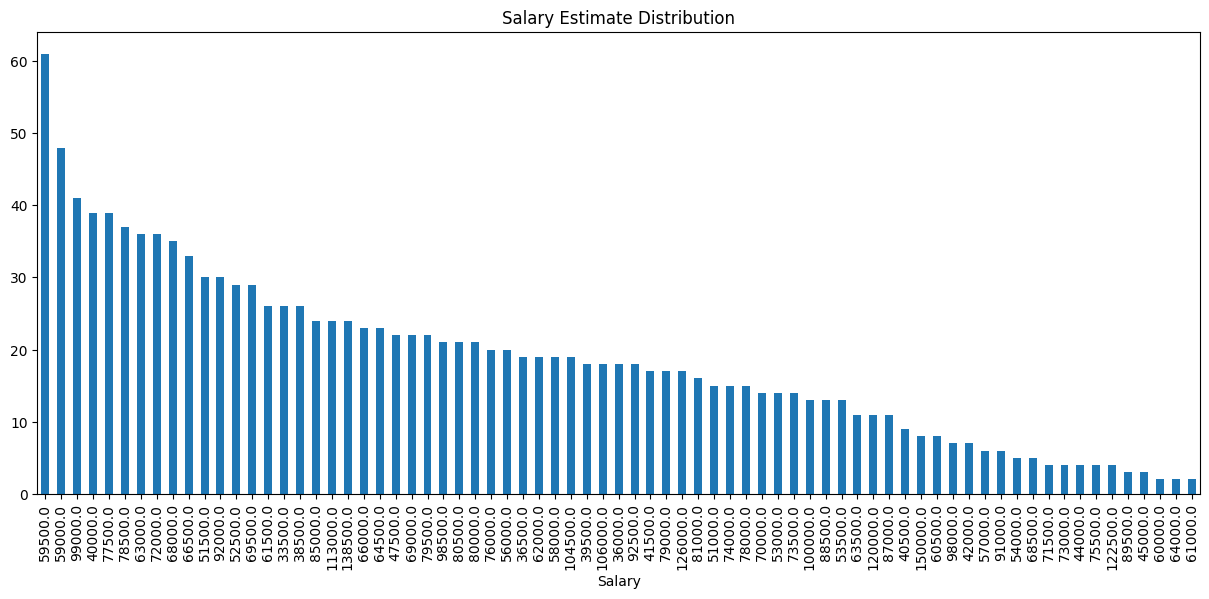

In [53]:
def plot_salary_estimate(dataset):
    # plot using matplotlib
    fig = plt.figure(figsize=(15, 6))
    dataset["Salary"].value_counts().plot(kind='bar')
    plt.xticks(rotation=90)
    plt.title("Salary Estimate Distribution")
    plt.show()
plot_salary_estimate(dataset)

/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_92252/282056191.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3', num_states)


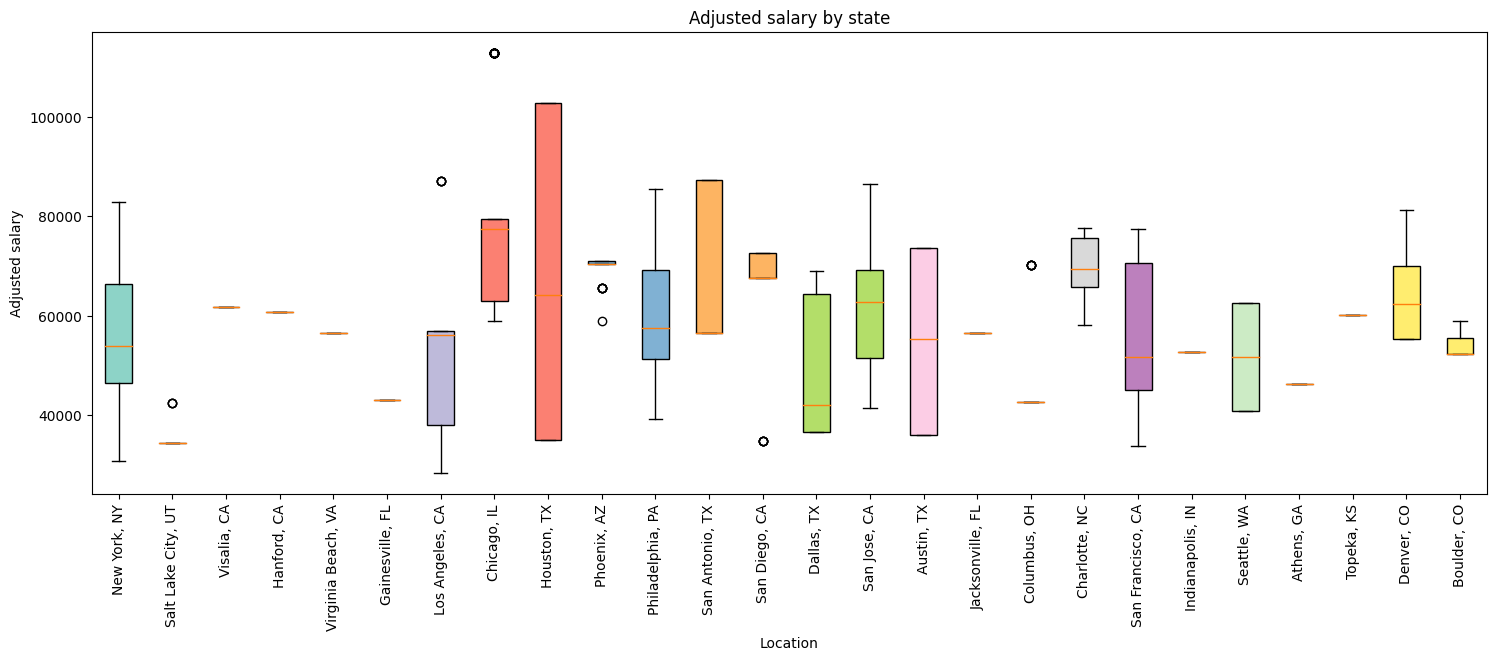

In [54]:
def plot_box(data):
    unique_states = data["Location"].unique()
    num_states = len(unique_states)


    colors = plt.cm.get_cmap('Set3', num_states)
    fig, ax = plt.subplots(figsize=(18, 6))
    boxplot = ax.boxplot([data[data["Location"] == state]["Adjusted salary"] for state in unique_states], patch_artist=True)

    # Assign a different color to each boxplot
    for patch, color in zip(boxplot['boxes'], colors(range(num_states))):
        patch.set_facecolor(color)

    ax.set_title("Adjusted salary by state")
    ax.set_ylabel("Adjusted salary")
    ax.set_xlabel("Location")
    ax.set_xticklabels(unique_states)
    plt.xticks(rotation=90)

    plt.show()

plot_box(dataset)

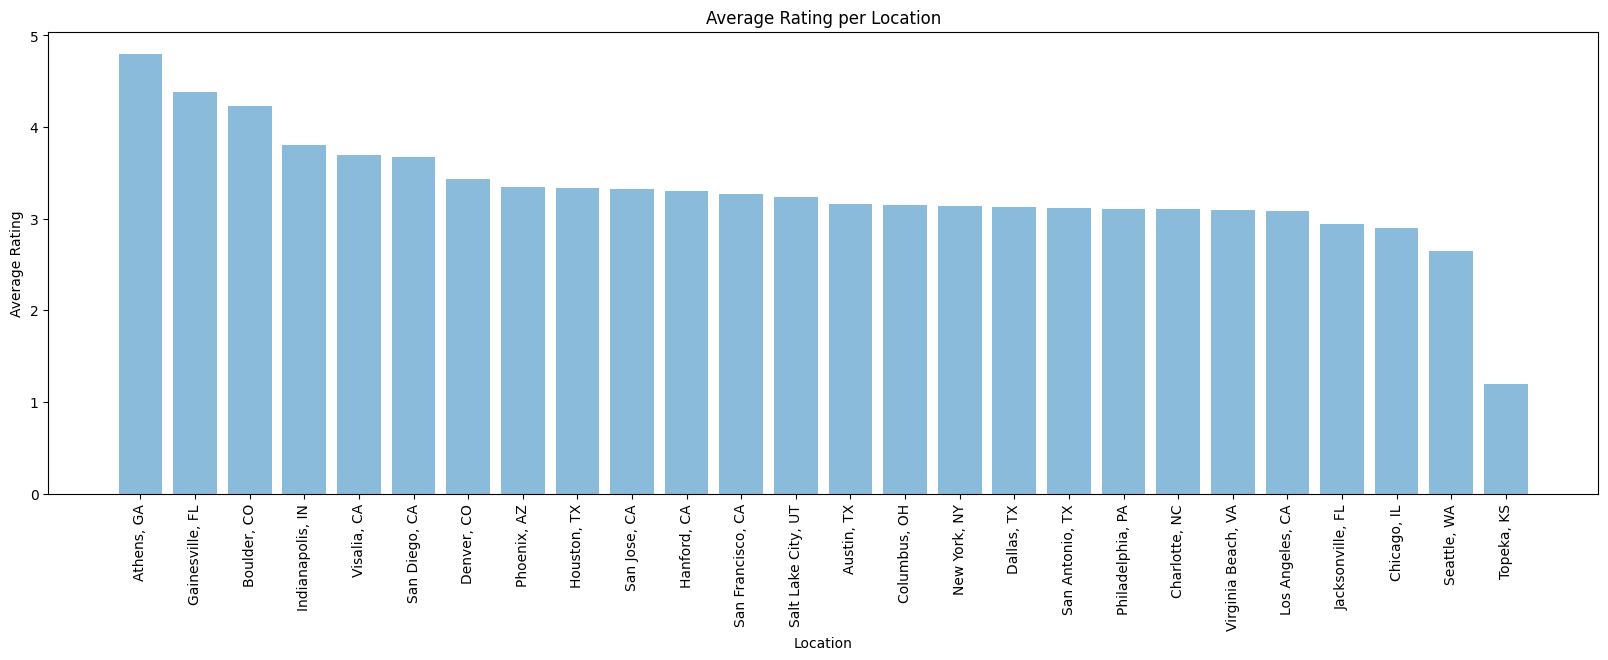

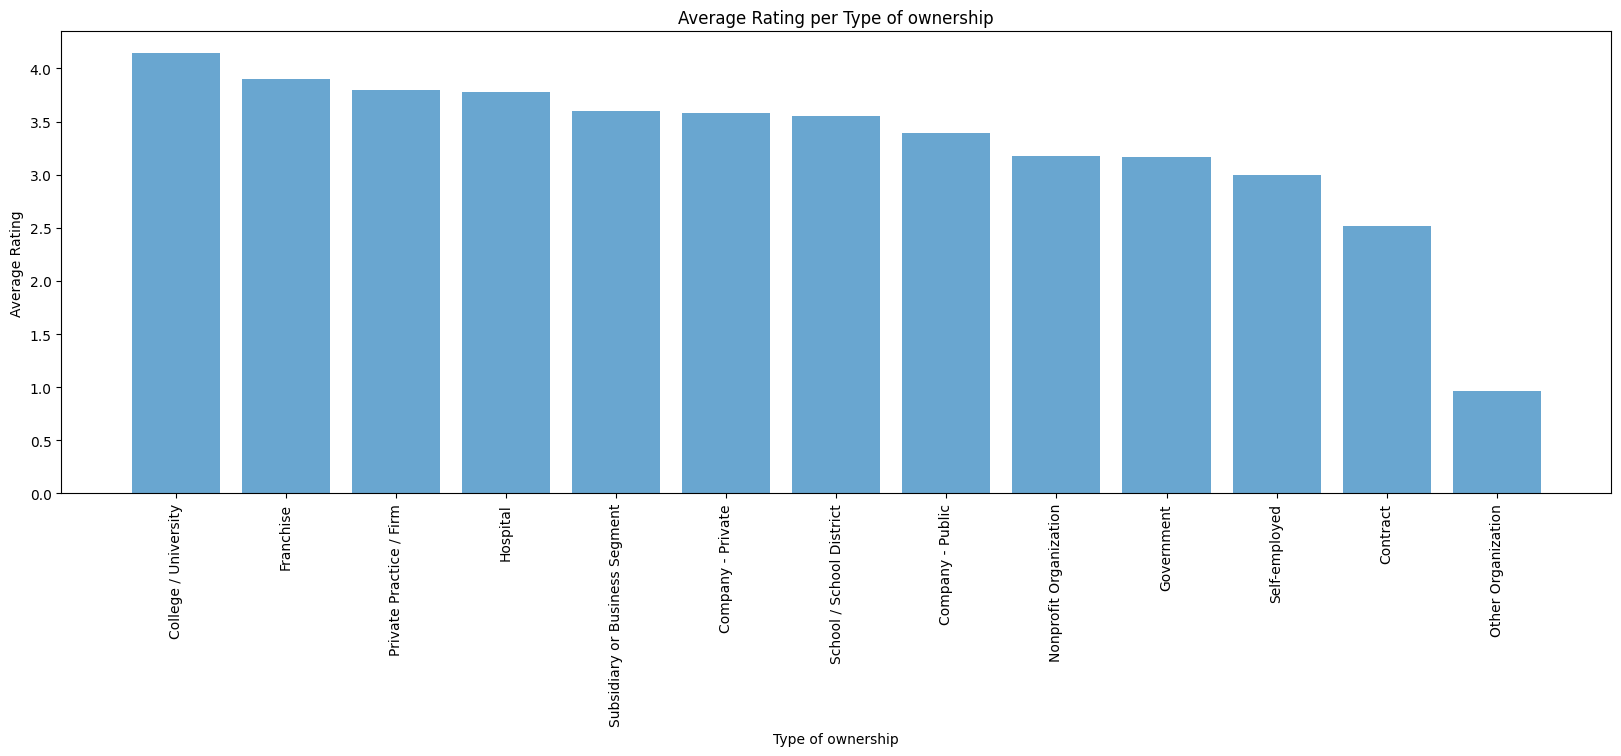

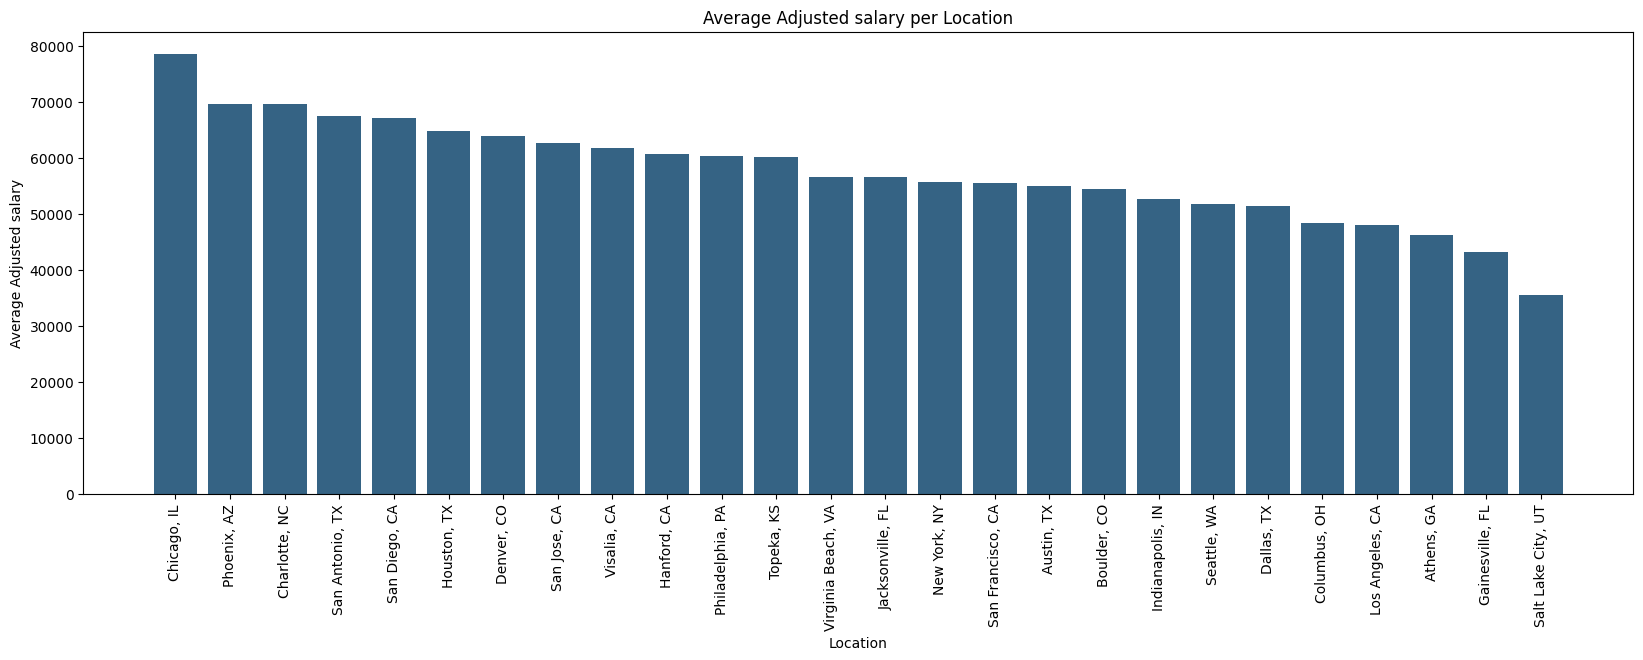

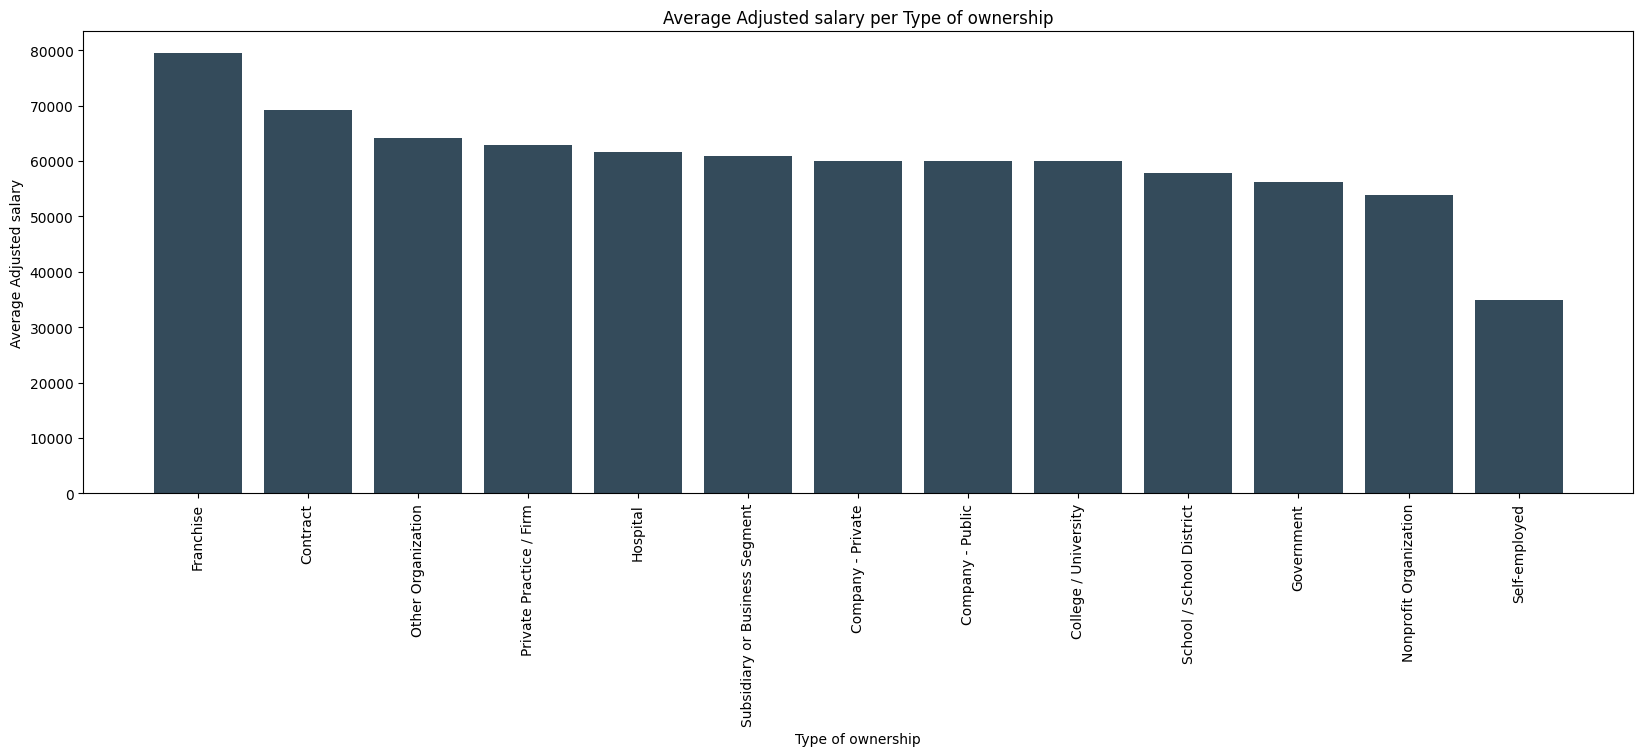

In [55]:
# get the average rating for each state
def plot_average_per_column(dataset, col, col2, color):
    avg = {}
    for i in dataset[col].unique():
        if i != "Not Available" and i != "Unknown":
            avg[i] = dataset[dataset[col] == i][col2].mean()
    
    # sort the dictionary by value
    avg = dict(sorted(avg.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(20, 6))
    plt.bar(avg.keys(), avg.values(), color=color)
    plt.title("Average " + col2 + " per " + col + "")
    plt.xlabel(col)
    plt.xticks(rotation=90)
    plt.ylabel("Average " + col2)
    plt.show()

avg_rating_per_state = plot_average_per_column(dataset, "Location", "Rating", colors[0])
avg_rating_ownership = plot_average_per_column(dataset, "Type of ownership", "Rating", colors[1])

# get the average adjusted salary for each state
avg_adjusted_salary_per_state = plot_average_per_column(dataset, "Location", "Adjusted salary", colors[4])
avg_adjusted_salary_per_ownership = plot_average_per_column(dataset, "Type of ownership", "Adjusted salary", colors[5])

In [56]:
# def delete_subsets(salary_ranges):
#     new_ranges = []
#     salary_ranges = sorted(salary_ranges, key=lambda x: x[0])
#     salary_ranges = sorted(salary_ranges, key=lambda x: x[-1])
#     if salary_ranges[0][0] == -1 and salary_ranges[0][1] == -1:
#         salary_ranges.pop(0)
#     i = 1
#     while i < len(salary_ranges):
#         if salary_ranges[i][0] >= salary_ranges[i-1][0] and salary_ranges[i][-1] <= salary_ranges[i-1][-1]:
            
#         else:
#             i += 1
#     return salary_ranges

# salary_ranges = delete_subsets(initial_salary_ranges)